In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp
from itertools import product


from sklearn.tree import plot_tree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer, KNNImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis

from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import lightgbm as lgb

from prince import MCA

import optuna


%matplotlib inline 
plt.style.use('dark_background')


In [58]:
clinical_df = pd.read_csv('Data/clinical_train.csv')
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_df = pd.read_csv('Data/molecular_train.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')
target_df = pd.read_csv('Data/target_train.csv')

## Data Preparation

In [59]:
target_df.dropna(inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool).map({True:1,False:0})

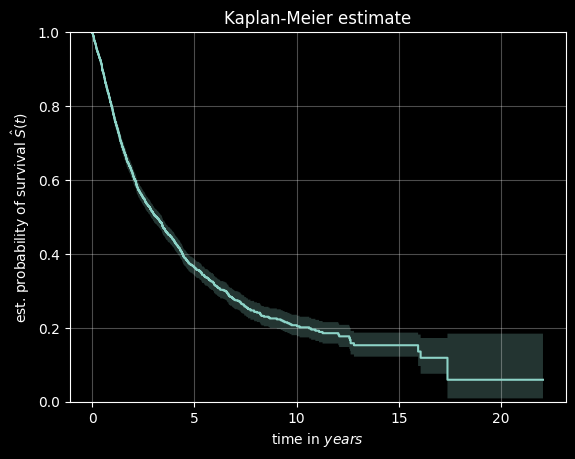

In [60]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    target_df["OS_STATUS"].astype(bool), target_df["OS_YEARS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time in $years$")
plt.title("Kaplan-Meier estimate")
plt.grid(alpha=0.3)
plt.show()

In [61]:
class CoxModelEvaluator:
    def __init__(self, X, y, n_splits=5, random_state=0):
        self.X = X
        self.y = y
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.cox_cindex_c_train_scores = []
        self.cox_cindex_c_test_scores = []
        self.alpha = 0
        self.cox_c = CoxPHSurvivalAnalysis(alpha=self.alpha)

    def evaluate_model(self, imputer=KNNImputer(n_neighbors=4),alpha=0):
        self.alpha = alpha
        self.cox_cindex_c_train_scores = [] # Rest previous scores
        self.cox_cindex_c_test_scores = []
        for train_index, test_index in self.kf.split(self.X,self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            imputer = imputer
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            self.cox_c.fit(X_train, y_train)

            cox_cindex_c_train = concordance_index_ipcw(y_train, y_train, self.cox_c.predict(X_train), tau=7)[0]
            cox_cindex_c_test = concordance_index_ipcw(y_train, y_test, self.cox_c.predict(X_test), tau=7)[0]

            self.cox_cindex_c_train_scores.append(cox_cindex_c_train)
            self.cox_cindex_c_test_scores.append(cox_cindex_c_test)

        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on train: {np.mean(self.cox_cindex_c_train_scores):.2f}")
        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on test: {np.mean(self.cox_cindex_c_test_scores):.2f}")

In [62]:
import re
def parse_cytogenetics(cytogenetics_str):
    modal_number_match = re.search(r'^\d+', cytogenetics_str)
    modal_number = modal_number_match.group() if modal_number_match else None  # Extract modal number
    sex_chromosomes_match = re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE)
    sex_chromosomes = sex_chromosomes_match.group() if sex_chromosomes_match else None  # Extract sex chromosomes
    abnormalities = re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', cytogenetics_str)
    subclones = re.findall(r'/\d+', cytogenetics_str)
    return {
        "modal_number": modal_number,
        "sex_chromosomes": sex_chromosomes,
        "abnormalities": abnormalities,
        "subclones": subclones
    }

# Example input
cytogenetics_str = clinical_df['CYTOGENETICS'].iloc[2]
parsed = parse_cytogenetics(cytogenetics_str)
print(parsed)


clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_df['GENDER'] = clinical_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_df['NUM_ABNORMALITIES'] = clinical_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_df['CHROMOSOME_DIFF'] = clinical_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

{'modal_number': '46', 'sex_chromosomes': 'xy', 'abnormalities': ['t(3;3)'], 'subclones': ['/46']}


In [63]:
X = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)


tmp = molecular_df.groupby('ID').size().reset_index(name='Nb mut')
X = X.merge(tmp, on='ID', how='left').fillna({'Nb mut': 0})

# X = X.drop(columns=['CYTOGENETICS','ID','GENDER','CENTER'])


In [64]:
X['MONOSOMY 9'] = X['CYTOGENETICS'].str.contains('-9').fillna(False).map({True: 1, False: 0})
X['MONOSOMY 7'] = X['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})


In [65]:
"""
mol_avg_vaf = molecular_df.groupby('ID')['VAF'].mean().reset_index()
mol_avg_vaf.columns = ['ID', 'avg_VAF'] 
X = X.merge(mol_avg_vaf, on='ID', how='left').fillna({'VAF': 0})
"""
mol_sum_vaf = molecular_df.groupby('ID')['VAF'].sum().reset_index()
mol_sum_vaf.columns = ['ID', 'sum_VAF']
X = X.merge(mol_sum_vaf, on='ID', how='left').fillna({'VAF': 0})

mol_sum_depth = molecular_df.groupby('ID')['DEPTH'].sum().reset_index()
mol_sum_depth.columns = ['ID', 'sum_depth']
X = X.merge(mol_sum_depth, on='ID', how='left').fillna({'VAF': 0})

molecular_df['X_mutation'] = molecular_df['CHR'].apply(lambda x: 1 if x == 'X' else 0)
mol_sum_X = molecular_df.groupby('ID')['X_mutation'].sum().reset_index()
mol_sum_X.columns = ['ID', 'sum_X']
X = X.merge(mol_sum_X, on='ID', how='left').fillna({'sum_X': 0})

In [66]:
clinical_df.isna().mean()

ID                   0.000000
CENTER               0.000000
BM_BLAST             0.032802
WBC                  0.081854
ANC                  0.058080
MONOCYTES            0.180861
HB                   0.033103
PLT                  0.037316
CYTOGENETICS         0.000000
GENDER               0.000000
NUM_ABNORMALITIES    0.000000
CHROMOSOME_DIFF      0.000000
dtype: float64

In [67]:
molecular_df.isna().mean()

ID                0.000000
CHR               0.010425
START             0.010425
END               0.010425
REF               0.010425
ALT               0.010425
GENE              0.000000
PROTEIN_CHANGE    0.001097
EFFECT            0.000000
VAF               0.008139
DEPTH             0.010425
X_mutation        0.000000
dtype: float64

In [68]:
coords = molecular_df[['CHR', 'START', 'END']].copy()
coords['CHR'] = coords['CHR'].dropna().apply(lambda x: float(23) if x == 'X' else float(x))
coords['START'] = coords['START'].fillna(coords['START'].mean())
coords['END'] = coords['END'].fillna(coords['END'].mean())
coords['CHR'] = coords['CHR'].fillna(coords['CHR'].mean())

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

dbscan = DBSCAN(eps=0.5, min_samples=6)
clusters = dbscan.fit_predict(coords_scaled)
coords['Cluster'] = clusters
coords.head()

molecular_df['Cluster'] = coords['Cluster']

In [69]:
#One hot encoding
categorical_cols = ['CHR','GENE','EFFECT','REF','ALT','Cluster','PROTEIN_CHANGE']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(molecular_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df['ID'] = molecular_df['ID']
encoded_group = encoded_df.groupby('ID').sum().reset_index()

"""
mca = MCA(n_components=10, n_iter=100, random_state=42) 
mca_features = mca.fit_transform(encoded_group.drop(columns=['ID']))
encoded_group = pd.DataFrame(mca_features, columns=[f'MCA_{i}' for i in range(mca_features.shape[1])])
encoded_group['ID'] = molecular_df['ID'].unique()
"""

"\nmca = MCA(n_components=10, n_iter=100, random_state=42) \nmca_features = mca.fit_transform(encoded_group.drop(columns=['ID']))\nencoded_group = pd.DataFrame(mca_features, columns=[f'MCA_{i}' for i in range(mca_features.shape[1])])\nencoded_group['ID'] = molecular_df['ID'].unique()\n"

In [70]:
encoded_group.head()

,ID,CHR_1,CHR_10,CHR_11,CHR_12,CHR_13,CHR_14,CHR_15,CHR_16,CHR_17,...,PROTEIN_CHANGE_p.Y874*,PROTEIN_CHANGE_p.Y889*,PROTEIN_CHANGE_p.Y899*,PROTEIN_CHANGE_p.Y89fs*44,PROTEIN_CHANGE_p.Y908C,PROTEIN_CHANGE_p.Y93fs*5,PROTEIN_CHANGE_p.Y974*,PROTEIN_CHANGE_p.Y974fs*10,PROTEIN_CHANGE_p.Y974fs*8,PROTEIN_CHANGE_nan
0,P100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P100006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
encoded_group = encoded_group.drop(columns=[col for col in encoded_group.drop(['ID'],axis=1).columns if encoded_group[col].sum() <= 5])
X = X.merge(encoded_group, on='ID', how='left')
#rare_columns = [col for col in X.drop(['ID', 'CENTER', 'CYTOGENETICS'], axis=1).columns if X[col].sum() <= 10]
#X = X.drop(columns=rare_columns)

In [84]:
nan_counts = X.isna().sum().sum()
print(nan_counts)

0


In [76]:
for col in X.columns[X.isna().mean() < 0.1]:
    if X[col].dtype in ['float64', 'int64']:
        X[col] = X[col].fillna(X[col].median())

In [15]:
encoded_df.head()

,CHR_1,CHR_10,CHR_11,CHR_12,CHR_13,CHR_14,CHR_15,CHR_16,CHR_17,CHR_18,...,PROTEIN_CHANGE_p.Y889*,PROTEIN_CHANGE_p.Y899*,PROTEIN_CHANGE_p.Y89fs*44,PROTEIN_CHANGE_p.Y908C,PROTEIN_CHANGE_p.Y93fs*5,PROTEIN_CHANGE_p.Y974*,PROTEIN_CHANGE_p.Y974fs*10,PROTEIN_CHANGE_p.Y974fs*8,PROTEIN_CHANGE_nan,ID
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000


In [16]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,0


In [17]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,0


In [18]:
molecular_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.?                  529
p.K700E              426
p.G646fs*12          370
p.P95H               246
p.P95L               148
                    ... 
p.L1244P               1
p.R1571fs*25           1
p.A258fs*3             1
p.E856fs*7             1
p.L1151_G1152insE      1
Name: count, Length: 4686, dtype: int64

In [81]:
X.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,GENDER,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


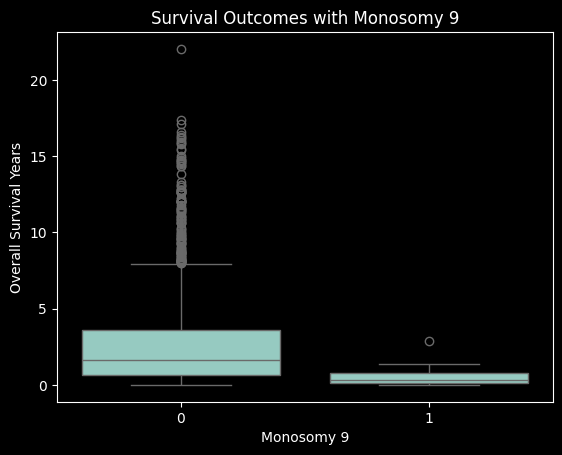

In [20]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 9', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 9')
plt.xlabel('Monosomy 9')
plt.ylabel('Overall Survival Years')
plt.show()


c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


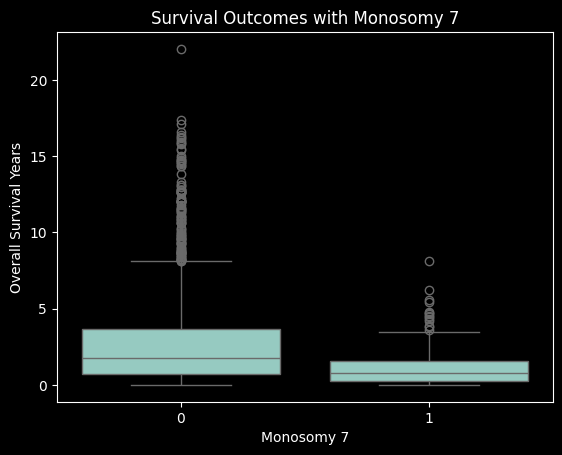

In [21]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 7', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 7')
plt.xlabel('Monosomy 7')
plt.ylabel('Overall Survival Years')
plt.show()


In [22]:
"""
merged = X.merge(target_df, on='ID', how='left')
correlation_matrix = merged.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
"""

'\nmerged = X.merge(target_df, on=\'ID\', how=\'left\')\ncorrelation_matrix = merged.corr()\nplt.figure(figsize=(12, 10))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\')\nplt.title(\'Correlation Matrix\')\nplt.show()\n'

In [82]:
drop_features = ['ID', 'CENTER', 'CYTOGENETICS']
X = X.drop(columns=drop_features)

In [83]:
imputer = KNNImputer(n_neighbors=5)
X_cols = X.columns
X = imputer.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)

In [24]:
"""
evaluator = CoxModelEvaluator(X, y)
evaluator.evaluate_model(imputer=KNNImputer(n_neighbors=10),alpha=0.000001)
"""

'\nevaluator = CoxModelEvaluator(X, y)\nevaluator.evaluate_model(imputer=KNNImputer(n_neighbors=10),alpha=0.000001)\n'

#### Feature Importance

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
#imputer = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors=6)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [86]:
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
y_train_lgb = y_train['OS_STATUS']

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

train_ci_ipcw = concordance_index_ipcw(y_train, y_train, lgbm_model.predict(X_train_lgb), tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, lgbm_model.predict(X_test_lgb), tau=7)[0]
print(f"Train CI IPCW: {train_ci_ipcw:.4f}")
print(f"Test CI IPCW: {test_ci_ipcw:.4f}")

Train CI IPCW: 0.8182
Test CI IPCW: 0.6700


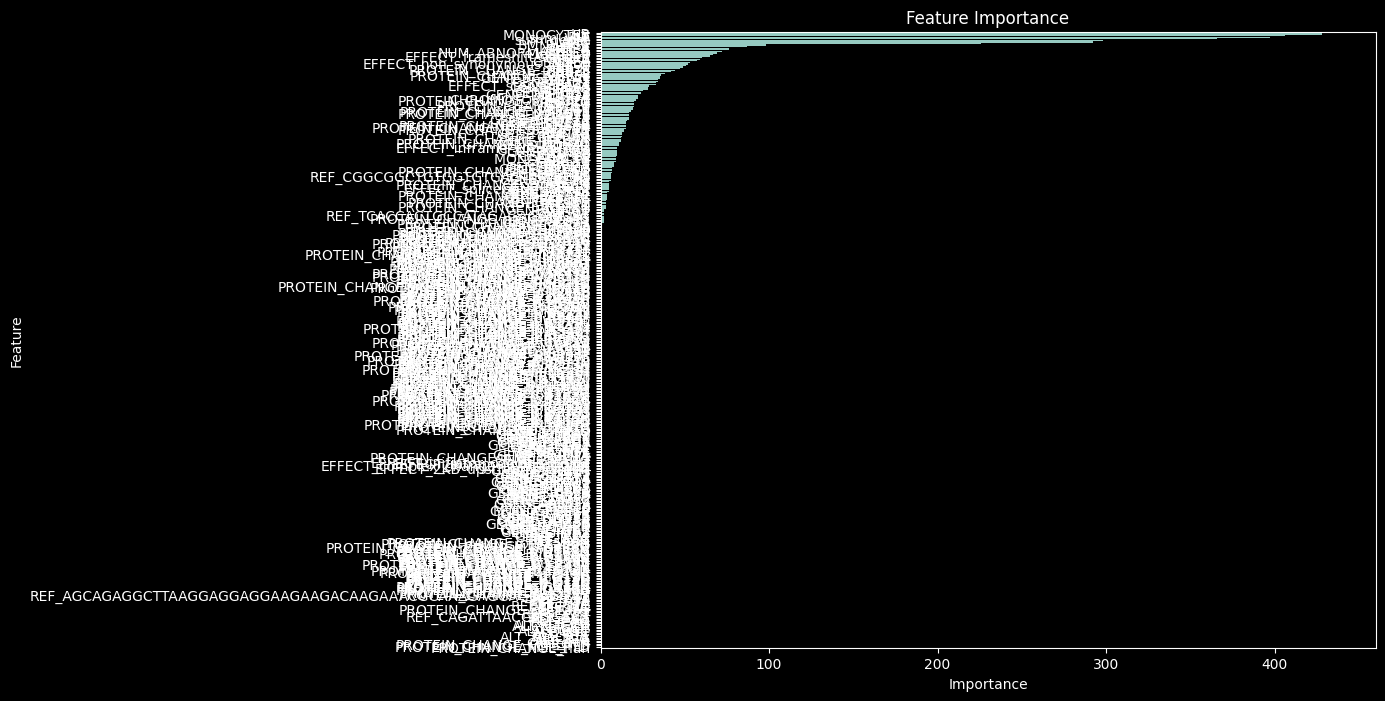

In [88]:
# Get feature importance
importance = lgbm_model.feature_importance()
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the feature importance dataframe
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_lgb)
plt.title('Feature Importance')
plt.show()

In [89]:
rf_params = {
    'max_depth': 3,
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train['OS_YEARS'])

train_ci_ipcw_rf = concordance_index_ipcw(y_train, y_train, rf_model.predict(X_train), tau=7)[0]
test_ci_ipcw_rf = concordance_index_ipcw(y_train, y_test, rf_model.predict(X_test), tau=7)[0]
print(f"Train CI IPCW RF: {train_ci_ipcw_rf:.4f}")
print(f"Test CI IPCW RF: {test_ci_ipcw_rf:.4f}")

Train CI IPCW RF: 0.2990
Test CI IPCW RF: 0.3267


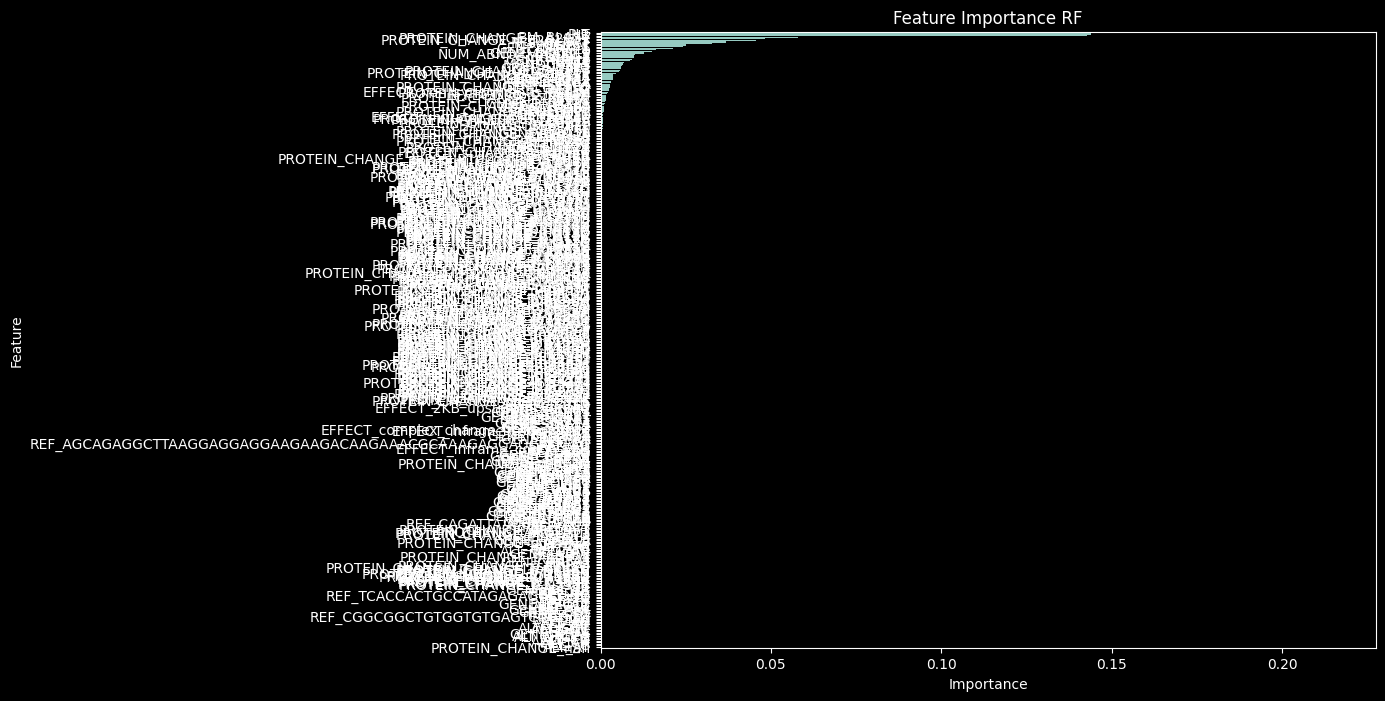

In [90]:
# Get feature importance
importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance_rf})
# Sort the feature importance dataframe
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance RF')
plt.show()


In [91]:
feature_importance_df_lgb.head(20)

,Feature,Importance
4,HB,438
3,MONOCYTES,428
5,PLT,406
12,sum_VAF,397
13,sum_depth,366
2,ANC,298
1,WBC,292
0,BM_BLAST,226
9,Nb mut,98
174,ALT_A,87


In [92]:
feature_importance_df_rf.head(20)

,Feature,Importance
5,PLT,0.216589
4,HB,0.143937
0,BM_BLAST,0.142651
212,PROTEIN_CHANGE_p.A213V,0.058024
229,PROTEIN_CHANGE_p.E261fs*3,0.048249
12,sum_VAF,0.045562
164,REF_GCTCT,0.036738
9,Nb mut,0.032677
15,CHR_1,0.025151
59,GENE_DDX41,0.024129


In [93]:
columns_to_use = feature_importance_df_lgb['Feature'].head(30).values
columns_to_use

array(['HB', 'MONOCYTES', 'PLT', 'sum_VAF', 'sum_depth', 'ANC', 'WBC',
       'BM_BLAST', 'Nb mut', 'ALT_A', 'CHR_4', 'REF_C',
       'NUM_ABNORMALITIES', 'Cluster_0', 'CHR_17',
       'EFFECT_frameshift_variant', 'CHR_5', 'REF_A', 'GENDER',
       'EFFECT_non_synonymous_codon', 'ALT_C', 'ALT_T', 'sum_X',
       'PROTEIN_CHANGE_p.K57E', 'REF_G', 'CHR_2', 'GENE_PRPF8',
       'PROTEIN_CHANGE_p.P95L', 'GENE_CSNK1A1', 'ALT_G'], dtype=object)

## Training

#### Random Survival Forest

In [172]:
class RandomSurvivalForestEvaluator:
    def __init__(self, X, y, n_estimators=200, min_samples_split=30, min_samples_leaf=15, max_features=0.5, max_depth= 5,random_state=42, n_jobs=-1, n_splits=5, imputer=KNNImputer(n_neighbors=6),scaler=MinMaxScaler()):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.rsf = RandomSurvivalForest(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state,
            max_depth=max_depth,
            n_jobs=n_jobs
        )
        self.rsf_cindex_train = []
        self.rsf_cindex_test = []
        self.imputer = imputer
        self.scaler = scaler

    def train(self):
        for train_index, test_index in self.kf.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            imputer = self.imputer
            #imputer = SimpleImputer(strategy='mean')
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
            
            
            self.rsf.fit(X_train, y_train)

            rsf_cindex_train_val = concordance_index_ipcw(y_train, y_train, self.rsf.predict(X_train), tau=7)[0]
            rsf_cindex_test_val = concordance_index_ipcw(y_train, y_test, self.rsf.predict(X_test), tau=7)[0]
            self.rsf_cindex_train.append(rsf_cindex_train_val)
            self.rsf_cindex_test.append(rsf_cindex_test_val)

    def get_scores(self):
        print(f"Average Random Survival Forest IPCW-Index train: {np.mean(self.rsf_cindex_train):.4f}")
        print(f"Average Random Survival Forest IPCW-Index test: {np.mean(self.rsf_cindex_test):.4f}")
    
    def score_reset(self):
        self.rsf_cindex_test = []
        self.rsf_cindex_train = []

In [95]:
def grid_search_rsf(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for RSF.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        # Initialize RSF with current parameter set
        rsf_params = dict(zip(param_names, params))
        rsf = RandomSurvivalForest(**rsf_params, random_state=42, n_jobs=-1)

        # Cross-validation setup
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Handle missing data
            imputer = SimpleImputer(strategy="mean")
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            # Fit RSF model
            rsf.fit(X_train, y_train)

            # Evaluate IPCW concordance index
            train_score = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        i += 1
        print(f"step {i}/{n}")
        # Average test score for this parameter set
        mean_test_score = np.mean(test_scores)
        print(f"Params: {rsf_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        # Update best parameters if the current score is better
        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = rsf_params

    return best_params, best_score


In [96]:
X_used = X.loc[:, columns_to_use]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_used)
X_scaled = pd.DataFrame(X_scaled, columns=X_used.columns)
evaluator = RandomSurvivalForestEvaluator(X_scaled, y)
evaluator.train()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [97]:
evaluator.get_scores()

Average Random Survival Forest IPCW-Index train: 0.7913
Average Random Survival Forest IPCW-Index test: 0.7078


In [192]:
param = {'n_estimators': 221, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.22011294765222877, 'max_depth': 9}

In [193]:
scaler_rsf = MinMaxScaler()
X_ = scaler_rsf.fit_transform(X)
X_ = pd.DataFrame(X_, columns=X.columns)

In [194]:
rsf = RandomSurvivalForest(**param, random_state=42, n_jobs=-1)
rsf.fit(X_, y)
train_ci_ipcw = concordance_index_ipcw(y, y, rsf.predict(X_), tau=7)[0]
print(f"Train CI IPCW: {train_ci_ipcw:.4f}")


Train CI IPCW: 0.7789


In [169]:
X_.head()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,0.153846,0.016861,0.001824,0.015837,0.285714,0.080745,1.0,0.047619,0.0,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010989,0.046693,0.021894,0.002262,0.603175,0.027605,0.0,0.000000,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.164835,0.022698,0.019157,0.002262,0.809524,0.054520,1.0,0.047619,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010989,0.023995,0.017333,0.002262,0.388889,0.051760,1.0,0.047619,0.0,0.647059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.065934,0.828794,0.088488,0.020362,0.563492,0.133195,0.0,0.047619,0.0,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
eval_rsf = RandomSurvivalForestEvaluator(X, y,**param)
eval_rsf.train()
eval_rsf.get_scores()


Average Random Survival Forest IPCW-Index train: 0.7840
Average Random Survival Forest IPCW-Index test: 0.7161


In [174]:
eval_rsf.rsf_cindex_test

[0.7132785901332412,
 0.707769248591667,
 0.7184096568353997,
 0.7225295821038751,
 0.7186671285594662]

In [ ]:
rsf_used = RandomSurvivalForestEvaluator(X_train, y_train,**param)
rsf_used.train()


In [879]:
"""
pca = PCA(0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
X_pca = pd.DataFrame(X_pca)
eval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)
eval_rsf_pca.train()
eval_rsf_pca.get_scores()
"""

'\npca = PCA(0.95)\nX_pca = pca.fit_transform(X)\nprint(X_pca.shape)\nprint(pca.explained_variance_ratio_)\nX_pca = pd.DataFrame(X_pca)\neval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)\neval_rsf_pca.train()\neval_rsf_pca.get_scores()\n'

In [880]:
param_grid = {
    "n_estimators": [100,200],
    "min_samples_split": [5, 10,30],
    "min_samples_leaf": [2, 5,20],
    "max_features": ["sqrt"],
    "max_depth": [None, 5, 15],
}

best_params, best_score = grid_search_rsf(X, y, param_grid, n_splits=5, tau=7)

print("\nBest Parameters:", best_params)
print("Best Test Concordance Index:", best_score)


In [163]:
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.Trial.suggest_float('max_features', 0.1, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)

    # Initialize the model with the suggested hyperparameters
    rsf = RandomSurvivalForest(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the model
    rsf.fit(X_train, y_train)

    # Evaluate the model
    test_score = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=7)[0]
    print(f"Test score: {test_score} and params: {trial.params}")
    return test_score

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)
print('Best score: ', study.best_value)

[I 2025-02-01 19:49:00,536] A new study created in memory with name: no-name-6591f70e-cf01-4a2e-9c1f-7a599c38f033
C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:02,154] Trial 0 finished with value: 0.7062080269009787 and parameters: {'n_estimators': 70, 'min_samples_split': 43, 'min_samples_leaf': 15, 'max_features': 0.12805407425980364, 'max_depth': 6}. Best is trial 0 with value: 0.7062080269009787.


Test score: 0.7062080269009787 and params: {'n_estimators': 70, 'min_samples_split': 43, 'min_samples_leaf': 15, 'max_features': 0.12805407425980364, 'max_depth': 6}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:08,099] Trial 1 finished with value: 0.70558738051172 and parameters: {'n_estimators': 293, 'min_samples_split': 29, 'min_samples_leaf': 5, 'max_features': 0.16170193876683572, 'max_depth': 5}. Best is trial 0 with value: 0.7062080269009787.


Test score: 0.70558738051172 and params: {'n_estimators': 293, 'min_samples_split': 29, 'min_samples_leaf': 5, 'max_features': 0.16170193876683572, 'max_depth': 5}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:11,946] Trial 2 finished with value: 0.7043786108169973 and parameters: {'n_estimators': 164, 'min_samples_split': 12, 'min_samples_leaf': 43, 'max_features': 0.31786836005341657, 'max_depth': 5}. Best is trial 0 with value: 0.7062080269009787.


Test score: 0.7043786108169973 and params: {'n_estimators': 164, 'min_samples_split': 12, 'min_samples_leaf': 43, 'max_features': 0.31786836005341657, 'max_depth': 5}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:20,397] Trial 3 finished with value: 0.7143459122121039 and parameters: {'n_estimators': 113, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 0.7081221530059806, 'max_depth': 8}. Best is trial 3 with value: 0.7143459122121039.


Test score: 0.7143459122121039 and params: {'n_estimators': 113, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 0.7081221530059806, 'max_depth': 8}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:25,395] Trial 4 finished with value: 0.7087752735393942 and parameters: {'n_estimators': 226, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': 0.25180670728764487, 'max_depth': 5}. Best is trial 3 with value: 0.7143459122121039.


Test score: 0.7087752735393942 and params: {'n_estimators': 226, 'min_samples_split': 8, 'min_samples_leaf': 22, 'max_features': 0.25180670728764487, 'max_depth': 5}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:34,220] Trial 5 finished with value: 0.7166050028877128 and parameters: {'n_estimators': 238, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 0.15025526693056546, 'max_depth': 13}. Best is trial 5 with value: 0.7166050028877128.


Test score: 0.7166050028877128 and params: {'n_estimators': 238, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 0.15025526693056546, 'max_depth': 13}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:42,393] Trial 6 finished with value: 0.6944700801779238 and parameters: {'n_estimators': 168, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.7283378724497359, 'max_depth': 4}. Best is trial 5 with value: 0.7166050028877128.


Test score: 0.6944700801779238 and params: {'n_estimators': 168, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.7283378724497359, 'max_depth': 4}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:44,951] Trial 7 finished with value: 0.7079810106330884 and parameters: {'n_estimators': 154, 'min_samples_split': 30, 'min_samples_leaf': 49, 'max_features': 0.135626992894762, 'max_depth': 18}. Best is trial 5 with value: 0.7166050028877128.


Test score: 0.7079810106330884 and params: {'n_estimators': 154, 'min_samples_split': 30, 'min_samples_leaf': 49, 'max_features': 0.135626992894762, 'max_depth': 18}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:49:51,364] Trial 8 finished with value: 0.7108703921234903 and parameters: {'n_estimators': 238, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.2243320775702774, 'max_depth': 6}. Best is trial 5 with value: 0.7166050028877128.


Test score: 0.7108703921234903 and params: {'n_estimators': 238, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.2243320775702774, 'max_depth': 6}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:50:10,043] Trial 9 finished with value: 0.716722247753564 and parameters: {'n_estimators': 261, 'min_samples_split': 26, 'min_samples_leaf': 9, 'max_features': 0.5518648769164874, 'max_depth': 10}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.716722247753564 and params: {'n_estimators': 261, 'min_samples_split': 26, 'min_samples_leaf': 9, 'max_features': 0.5518648769164874, 'max_depth': 10}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:50:35,663] Trial 10 finished with value: 0.7138577926394792 and parameters: {'n_estimators': 299, 'min_samples_split': 41, 'min_samples_leaf': 31, 'max_features': 0.9675245012916098, 'max_depth': 13}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7138577926394792 and params: {'n_estimators': 299, 'min_samples_split': 41, 'min_samples_leaf': 31, 'max_features': 0.9675245012916098, 'max_depth': 13}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:50:49,105] Trial 11 finished with value: 0.7155958433467552 and parameters: {'n_estimators': 237, 'min_samples_split': 21, 'min_samples_leaf': 18, 'max_features': 0.43446424332245814, 'max_depth': 13}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7155958433467552 and params: {'n_estimators': 237, 'min_samples_split': 21, 'min_samples_leaf': 18, 'max_features': 0.43446424332245814, 'max_depth': 13}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:50:59,670] Trial 12 finished with value: 0.7108435728828785 and parameters: {'n_estimators': 219, 'min_samples_split': 23, 'min_samples_leaf': 31, 'max_features': 0.46149109661104454, 'max_depth': 10}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7108435728828785 and params: {'n_estimators': 219, 'min_samples_split': 23, 'min_samples_leaf': 31, 'max_features': 0.46149109661104454, 'max_depth': 10}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:51:19,495] Trial 13 finished with value: 0.7148984363893649 and parameters: {'n_estimators': 265, 'min_samples_split': 33, 'min_samples_leaf': 12, 'max_features': 0.3907362769803028, 'max_depth': 15}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7148984363893649 and params: {'n_estimators': 265, 'min_samples_split': 33, 'min_samples_leaf': 12, 'max_features': 0.3907362769803028, 'max_depth': 15}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:51:41,646] Trial 14 finished with value: 0.6982968932472975 and parameters: {'n_estimators': 200, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': 0.5549876910559993, 'max_depth': 10}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.6982968932472975 and params: {'n_estimators': 200, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': 0.5549876910559993, 'max_depth': 10}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:51:52,842] Trial 15 finished with value: 0.7137181282914303 and parameters: {'n_estimators': 266, 'min_samples_split': 36, 'min_samples_leaf': 25, 'max_features': 0.3256860988408977, 'max_depth': 16}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7137181282914303 and params: {'n_estimators': 266, 'min_samples_split': 36, 'min_samples_leaf': 25, 'max_features': 0.3256860988408977, 'max_depth': 16}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:52:15,374] Trial 16 finished with value: 0.7146755976659293 and parameters: {'n_estimators': 196, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 0.549605595173222, 'max_depth': 19}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7146755976659293 and params: {'n_estimators': 196, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 0.549605595173222, 'max_depth': 19}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:52:29,825] Trial 17 finished with value: 0.7116522783185864 and parameters: {'n_estimators': 261, 'min_samples_split': 49, 'min_samples_leaf': 19, 'max_features': 0.28474710678835286, 'max_depth': 11}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7116522783185864 and params: {'n_estimators': 261, 'min_samples_split': 49, 'min_samples_leaf': 19, 'max_features': 0.28474710678835286, 'max_depth': 11}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:52:33,682] Trial 18 finished with value: 0.7067661566156412 and parameters: {'n_estimators': 138, 'min_samples_split': 25, 'min_samples_leaf': 31, 'max_features': 0.10855683828888552, 'max_depth': 8}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7067661566156412 and params: {'n_estimators': 138, 'min_samples_split': 25, 'min_samples_leaf': 31, 'max_features': 0.10855683828888552, 'max_depth': 8}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:52:45,368] Trial 19 finished with value: 0.7152718337612298 and parameters: {'n_estimators': 193, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 0.21274763710364375, 'max_depth': 13}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7152718337612298 and params: {'n_estimators': 193, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 0.21274763710364375, 'max_depth': 13}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:53:01,313] Trial 20 finished with value: 0.7145884490828329 and parameters: {'n_estimators': 274, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 0.36208128016055063, 'max_depth': 16}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7145884490828329 and params: {'n_estimators': 274, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 0.36208128016055063, 'max_depth': 16}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:53:15,400] Trial 21 finished with value: 0.7154096650975373 and parameters: {'n_estimators': 244, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': 0.4400485433677943, 'max_depth': 13}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7154096650975373 and params: {'n_estimators': 244, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': 0.4400485433677943, 'max_depth': 13}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:53:30,592] Trial 22 finished with value: 0.7150894527331119 and parameters: {'n_estimators': 215, 'min_samples_split': 26, 'min_samples_leaf': 16, 'max_features': 0.5040023920073808, 'max_depth': 14}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7150894527331119 and params: {'n_estimators': 215, 'min_samples_split': 26, 'min_samples_leaf': 16, 'max_features': 0.5040023920073808, 'max_depth': 14}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:53:43,177] Trial 23 finished with value: 0.7138974798994064 and parameters: {'n_estimators': 245, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.3869393472791314, 'max_depth': 8}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7138974798994064 and params: {'n_estimators': 245, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.3869393472791314, 'max_depth': 8}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:54:31,484] Trial 24 finished with value: 0.6978034170147794 and parameters: {'n_estimators': 279, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.6067077704929805, 'max_depth': 11}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.6978034170147794 and params: {'n_estimators': 279, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 0.6067077704929805, 'max_depth': 11}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:54:42,455] Trial 25 finished with value: 0.7096875441919529 and parameters: {'n_estimators': 248, 'min_samples_split': 30, 'min_samples_leaf': 25, 'max_features': 0.2077397927268966, 'max_depth': 12}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7096875441919529 and params: {'n_estimators': 248, 'min_samples_split': 30, 'min_samples_leaf': 25, 'max_features': 0.2077397927268966, 'max_depth': 12}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:54:55,942] Trial 26 finished with value: 0.7137456666092719 and parameters: {'n_estimators': 209, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.28652716420365126, 'max_depth': 9}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7137456666092719 and params: {'n_estimators': 209, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.28652716420365126, 'max_depth': 9}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:55:14,403] Trial 27 finished with value: 0.7144352415237777 and parameters: {'n_estimators': 229, 'min_samples_split': 36, 'min_samples_leaf': 18, 'max_features': 0.41800018072041933, 'max_depth': 15}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7144352415237777 and params: {'n_estimators': 229, 'min_samples_split': 36, 'min_samples_leaf': 18, 'max_features': 0.41800018072041933, 'max_depth': 15}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:55:32,493] Trial 28 finished with value: 0.715853236513034 and parameters: {'n_estimators': 185, 'min_samples_split': 26, 'min_samples_leaf': 6, 'max_features': 0.3238404019964371, 'max_depth': 18}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.715853236513034 and params: {'n_estimators': 185, 'min_samples_split': 26, 'min_samples_leaf': 6, 'max_features': 0.3238404019964371, 'max_depth': 18}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:55:36,329] Trial 29 finished with value: 0.7091473471405658 and parameters: {'n_estimators': 55, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 0.179599437082742, 'max_depth': 20}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7091473471405658 and params: {'n_estimators': 55, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 0.179599437082742, 'max_depth': 20}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:55:41,261] Trial 30 finished with value: 0.7118049231096354 and parameters: {'n_estimators': 93, 'min_samples_split': 28, 'min_samples_leaf': 7, 'max_features': 0.13119394408165583, 'max_depth': 18}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7118049231096354 and params: {'n_estimators': 93, 'min_samples_split': 28, 'min_samples_leaf': 7, 'max_features': 0.13119394408165583, 'max_depth': 18}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:55:54,104] Trial 31 finished with value: 0.7134742956628735 and parameters: {'n_estimators': 180, 'min_samples_split': 23, 'min_samples_leaf': 15, 'max_features': 0.3212742576446501, 'max_depth': 17}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7134742956628735 and params: {'n_estimators': 180, 'min_samples_split': 23, 'min_samples_leaf': 15, 'max_features': 0.3212742576446501, 'max_depth': 17}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:56:18,094] Trial 32 finished with value: 0.7166639751793554 and parameters: {'n_estimators': 282, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.24841521707087844, 'max_depth': 12}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7166639751793554 and params: {'n_estimators': 282, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.24841521707087844, 'max_depth': 12}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)


Test score: 0.7155315143554039 and params: {'n_estimators': 289, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 0.17981632510639683, 'max_depth': 12}


[I 2025-02-01 19:56:43,852] Trial 33 finished with value: 0.7155315143554039 and parameters: {'n_estimators': 289, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 0.17981632510639683, 'max_depth': 12}. Best is trial 9 with value: 0.716722247753564.
C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:56:55,455] Trial 34 finished with value: 0.7110696861881769 and parameters: {'n_estimators': 286, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.10198152802561544, 'max_depth': 7}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7110696861881769 and params: {'n_estimators': 286, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.10198152802561544, 'max_depth': 7}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:57:10,829] Trial 35 finished with value: 0.7148937718077962 and parameters: {'n_estimators': 256, 'min_samples_split': 33, 'min_samples_leaf': 12, 'max_features': 0.25478449369959094, 'max_depth': 10}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7148937718077962 and params: {'n_estimators': 256, 'min_samples_split': 33, 'min_samples_leaf': 12, 'max_features': 0.25478449369959094, 'max_depth': 10}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:57:14,050] Trial 36 finished with value: 0.6976249169735484 and parameters: {'n_estimators': 127, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.16054902764150583, 'max_depth': 3}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.6976249169735484 and params: {'n_estimators': 127, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.16054902764150583, 'max_depth': 3}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:57:20,558] Trial 37 finished with value: 0.7094314154931184 and parameters: {'n_estimators': 152, 'min_samples_split': 7, 'min_samples_leaf': 38, 'max_features': 0.2504237326603308, 'max_depth': 14}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7094314154931184 and params: {'n_estimators': 152, 'min_samples_split': 7, 'min_samples_leaf': 38, 'max_features': 0.2504237326603308, 'max_depth': 14}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:57:35,272] Trial 38 finished with value: 0.7132128770182747 and parameters: {'n_estimators': 181, 'min_samples_split': 27, 'min_samples_leaf': 10, 'max_features': 0.32022151941026117, 'max_depth': 20}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7132128770182747 and params: {'n_estimators': 181, 'min_samples_split': 27, 'min_samples_leaf': 10, 'max_features': 0.32022151941026117, 'max_depth': 20}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:57:49,832] Trial 39 finished with value: 0.7048546667044832 and parameters: {'n_estimators': 275, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 0.16396150941427734, 'max_depth': 9}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7048546667044832 and params: {'n_estimators': 275, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 0.16396150941427734, 'max_depth': 9}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:58:08,248] Trial 40 finished with value: 0.7091334104085782 and parameters: {'n_estimators': 297, 'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': 0.3709912354281477, 'max_depth': 6}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7091334104085782 and params: {'n_estimators': 297, 'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': 0.3709912354281477, 'max_depth': 6}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:58:25,989] Trial 41 finished with value: 0.7156514380465439 and parameters: {'n_estimators': 254, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.26089355291974525, 'max_depth': 12}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7156514380465439 and params: {'n_estimators': 254, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.26089355291974525, 'max_depth': 12}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:58:42,431] Trial 42 finished with value: 0.7165248776688345 and parameters: {'n_estimators': 231, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.2685411078923591, 'max_depth': 11}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7165248776688345 and params: {'n_estimators': 231, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.2685411078923591, 'max_depth': 11}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:58:54,410] Trial 43 finished with value: 0.7148312834132128 and parameters: {'n_estimators': 231, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 0.20621030667493245, 'max_depth': 11}. Best is trial 9 with value: 0.716722247753564.


Test score: 0.7148312834132128 and params: {'n_estimators': 231, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 0.20621030667493245, 'max_depth': 11}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:07,219] Trial 44 finished with value: 0.7181975841850358 and parameters: {'n_estimators': 221, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.22011294765222877, 'max_depth': 9}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7181975841850358 and params: {'n_estimators': 221, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.22011294765222877, 'max_depth': 9}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:16,852] Trial 45 finished with value: 0.7166530396302154 and parameters: {'n_estimators': 223, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.13850491871532913, 'max_depth': 9}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7166530396302154 and params: {'n_estimators': 223, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.13850491871532913, 'max_depth': 9}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:24,489] Trial 46 finished with value: 0.7113768159275835 and parameters: {'n_estimators': 217, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.12518202058894584, 'max_depth': 7}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7113768159275835 and params: {'n_estimators': 217, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.12518202058894584, 'max_depth': 7}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:34,969] Trial 47 finished with value: 0.7101996169569293 and parameters: {'n_estimators': 205, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.1533871133870667, 'max_depth': 9}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7101996169569293 and params: {'n_estimators': 205, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.1533871133870667, 'max_depth': 9}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:51,836] Trial 48 finished with value: 0.7157738324420465 and parameters: {'n_estimators': 265, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.22451346107493692, 'max_depth': 10}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7157738324420465 and params: {'n_estimators': 265, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.22451346107493692, 'max_depth': 10}


C:\Users\Loïc\AppData\Local\Temp\ipykernel_2072\4277584921.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_features = trial.suggest_uniform('max_features', 0.1, 1.0)
[I 2025-02-01 19:59:56,243] Trial 49 finished with value: 0.7072934371326621 and parameters: {'n_estimators': 168, 'min_samples_split': 11, 'min_samples_leaf': 48, 'max_features': 0.1377549776731467, 'max_depth': 7}. Best is trial 44 with value: 0.7181975841850358.


Test score: 0.7072934371326621 and params: {'n_estimators': 168, 'min_samples_split': 11, 'min_samples_leaf': 48, 'max_features': 0.1377549776731467, 'max_depth': 7}
Best hyperparameters:  {'n_estimators': 221, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.22011294765222877, 'max_depth': 9}
Best score:  0.7181975841850358


#### Gradient Boosting Survival Analysis

In [156]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [157]:
param = {'n_estimators': 185,
  'learning_rate': 0.05,
  'max_depth': 3,
  'subsample': 0.8}

est_cph_tree = GradientBoostingSurvivalAnalysis(**param,random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)

gbs_cindex_test_val = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
gbs_cindex_train_val = concordance_index_ipcw(y_train, y_train, est_cph_tree.predict(X_train), tau=7)[0]

print(round(cindex, 4))
print(f'train ipcw score : {round(gbs_cindex_train_val, 4)}')
print(f'test ipcw score : {round(gbs_cindex_test_val, 4)}')



0.7368
train ipcw score : 0.7655
test ipcw score : 0.7205


In [108]:
def grid_search_gbs(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for gbs.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        gbs_params = dict(zip(param_names, params))
        gbs = GradientBoostingSurvivalAnalysis(**gbs_params, random_state=42)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            imputer = KNNImputer(n_neighbors=15)
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            gbs.fit(X_train, y_train)

            train_score = concordance_index_ipcw(y_train, y_train, gbs.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, gbs.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        i += 1
        print(f"step {i}/{n}")

        mean_test_score = np.mean(test_scores)
        print(f"Params: {gbs_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = gbs_params

    return best_params, best_score

In [883]:
#without protein_changes 
print(({'n_estimators': 50, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8},
 0.7182145046514242))


({'n_estimators': 50, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}, 0.7182145046514242)


In [884]:
#with protein_changes
print(({'n_estimators': 150,
  'learning_rate': 0.05,
  'max_depth': 3,
  'subsample': 0.8},
 0.7184572349665073))

({'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}, 0.7184572349665073)


In [109]:
param_grid_gbs = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0]
}

#grid_search_gbs(X_, y, param_grid_gbs, n_splits=5, tau=7)

In [158]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    """
    imputer = KNNImputer(n_neighbors=10)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    """
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    est_cph_tree.fit(X_train, y_train)
    cindex = est_cph_tree.score(X_test, y_test)

    gbs_cindex_test_val = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
    gbs_cindex_train_val = concordance_index_ipcw(y_train, y_train, est_cph_tree.predict(X_train), tau=7)[0]

    scores.append((cindex, gbs_cindex_train_val, gbs_cindex_test_val))

avg_cindex = np.mean([score[0] for score in scores])
avg_train_ipcw = np.mean([score[1] for score in scores])
avg_test_ipcw = np.mean([score[2] for score in scores])

print(f'Average C-index: {round(avg_cindex, 4)}')
print(f'Average train IPCW score: {round(avg_train_ipcw, 4)}')
print(f'Average test IPCW score: {round(avg_test_ipcw, 4)}')

Average C-index: 0.7362
Average train IPCW score: 0.7658
Average test IPCW score: 0.7167


In [159]:
scores

[(0.7427791475871786, 0.7658051397978505, 0.7183311210958642),
 (0.7222628283593262, 0.7689330002140149, 0.700225458453556),
 (0.7423749932282355, 0.7630794399835481, 0.7232911064616578),
 (0.7366039049580783, 0.7654121698997112, 0.720914883369186),
 (0.7367799443980014, 0.765530622566881, 0.7205402370209607)]

In [888]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=3, random_state=0)
for i in range(1, 2):
    n_estimators = i * 10
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]
    #scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

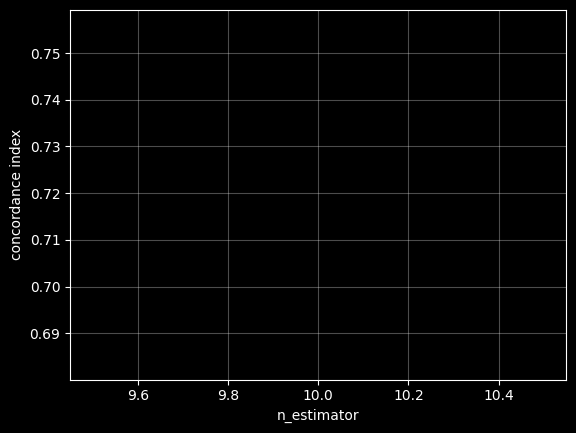

In [889]:
x_p, y_p = zip(*scores_cph_tree.items())
plt.plot(x_p, y_p)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(alpha=0.3)
plt.show()

In [890]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.8, max_depth=3, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)
ipcw_test = concordance_index_ipcw(y_train, y_test, est_early_stopping.predict(X_test), tau=7)[0]
cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 43))
print("IPCW concordance index", round(ipcw_test, 4))

Fitted base learners: 185
Performance on test set 0.7551390732064025
IPCW concordance index 0.7314


### TEST

In [176]:
print(molecular_test_df.isna().sum().sum())
print(clinical_test_df.isna().sum().sum())

550
1477


In [892]:
clinical_test_df.head(10)

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]"
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de..."
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8"
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r..."
5,KYW6,KYW,27.0,1.35,0.3915,NaN,4.1,148.0,Normal
6,KYW7,KYW,2.0,6.90,5.2095,NaN,7.5,94.0,"46,XY,del(11)(q?)"
7,KYW8,KYW,9.0,5.73,3.8391,NaN,7.8,195.0,"46,XY,del(5)(q13q15)[20]"
8,KYW9,KYW,2.0,NaN,NaN,NaN,NaN,NaN,Normal
9,KYW10,KYW,1.0,1.61,0.6118,NaN,9.9,85.0,"47,XY,+8"


In [893]:
molecular_test_df.head(10)

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,KYW961,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.262,485.0
1,KYW142,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.028,527.0
2,KYW453,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.292,277.0
3,KYW982,1,1747229.0,1747229.0,T,C,GNB1,p.K57E,non_synonymous_codon,0.097,821.0
4,KYW845,1,36932209.0,36932209.0,G,A,CSF3R,p.Q754X,stop_gained,0.430,358.0
5,KYW907,1,36932209.0,36932209.0,G,A,CSF3R,p.Q754X,stop_gained,0.054,687.0
6,KYW926,1,36932213.0,36932213.0,A,-,CSF3R,p.Y752X,stop_gained,0.118,501.0
7,KYW12,1,36932213.0,36932213.0,-,T,CSF3R,p.Y752_G753delinsX,stop_gained,0.667,418.0
8,KYW810,1,36932215.0,36932215.0,-,TT,CSF3R,p.Y752fs,frameshift_variant,0.137,607.0
9,KYW810,1,36932219.0,36932219.0,-,C,CSF3R,p.V750fs,frameshift_variant,0.140,593.0


In [177]:
molecular_df['PROTEIN_CHANGE'].isna().sum()

12

In [178]:
molecular_test_df['PROTEIN_CHANGE'].value_counts()[:20]

PROTEIN_CHANGE
p.L287fs       53
p.P95H         48
p.K700E        48
p.R525H        45
p.N155S        44
p.S34F         42
p.P499fs       40
p.R140Q        39
FLT3_ITD       36
MLL_PTD        33
p.Q157P        32
p.H630fs       30
p.R882H        29
p.G12D         25
p.R882C        24
p.V617F        23
p.P95L         21
p.G870S        20
p.95_103del    18
p.R132C        18
Name: count, dtype: int64

In [179]:
molecular_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.?                  529
p.K700E              426
p.G646fs*12          370
p.P95H               246
p.P95L               148
                    ... 
p.L1244P               1
p.R1571fs*25           1
p.A258fs*3             1
p.E856fs*7             1
p.L1151_G1152insE      1
Name: count, Length: 4686, dtype: int64

In [195]:
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')

In [121]:
known_protein_changes = set(molecular_df['PROTEIN_CHANGE'].unique())

#molecular_test_df['PROTEIN_CHANGE'] = molecular_test_df['PROTEIN_CHANGE'].apply(lambda x: x if x in known_protein_changes else 'p.?')

In [181]:
molecular_test_df['PROTEIN_CHANGE'].value_counts()

PROTEIN_CHANGE
p.L287fs    53
p.P95H      48
p.K700E     48
p.R525H     45
p.N155S     44
            ..
p.P419fs     1
p.R476X      1
p.E482fs     1
p.E491X      1
p.R232fs     1
Name: count, Length: 1589, dtype: int64

In [196]:
#TEST DF

clinical_test_df['CYTOGENETICS'] = clinical_test_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_test_df['GENDER'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_test_df['NUM_ABNORMALITIES'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_test_df['CHROMOSOME_DIFF'] = clinical_test_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

# Handle 'Normal' values in 'CYTOGENETICS'
#clinical_test_df.loc[clinical_test_df['CYTOGENETICS'] == 'Normal', ['NUM_ABNORMALITIES', 'CHROMOSOME_DIFF', 'GENDER']] = [0, 0, 0.5]

X_test_sub = clinical_test_df.copy()

tmp_test = molecular_test_df.groupby('ID').size().reset_index(name='Nb mut')
X_test_sub = X_test_sub.merge(tmp_test, on='ID', how='left').fillna({'Nb mut': 0})

X_test_sub['MONOSOMY 9'] = X_test_sub['CYTOGENETICS'].str.contains('-9').fillna(False).map({True: 1, False: 0})
X_test_sub['MONOSOMY 7'] = X_test_sub['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})

mol_sum_vaf_test = molecular_test_df.groupby('ID')['VAF'].sum().reset_index()
mol_sum_vaf_test.columns = ['ID', 'sum_VAF']
X_test_sub = X_test_sub.merge(mol_sum_vaf_test, on='ID', how='left').fillna({'VAF': 0})

mol_sum_depth_test = molecular_test_df.groupby('ID')['DEPTH'].sum().reset_index()
mol_sum_depth_test.columns = ['ID', 'sum_depth']
X_test_sub = X_test_sub.merge(mol_sum_depth_test, on='ID', how='left').fillna({'VAF': 0})

molecular_test_df['X_mutation'] = molecular_test_df['CHR'].apply(lambda x: 1 if x == 'X' else 0)
mol_sum_X_test = molecular_test_df.groupby('ID')['X_mutation'].sum().reset_index()
mol_sum_X_test.columns = ['ID', 'sum_X']
X_test_sub = X_test_sub.merge(mol_sum_X_test, on='ID', how='left').fillna({'sum_X': 0})




coords_test = molecular_test_df[['CHR', 'START', 'END']].copy()
coords_test['CHR'] = coords_test['CHR'].dropna().apply(lambda x: float(23) if x == 'X' else float(x))
coords_test['START'] = coords_test['START'].fillna(coords_test['START'].mean())
coords_test['END'] = coords_test['END'].fillna(coords_test['END'].mean())
coords_test['CHR'] = coords_test['CHR'].fillna(coords_test['CHR'].mean())

scaler = StandardScaler()
coords_test_scaled = scaler.fit_transform(coords_test)

clusters_test = dbscan.fit_predict(coords_test_scaled)
coords_test['Cluster'] = clusters_test

molecular_test_df['Cluster'] = coords_test['Cluster']




categorical_cols_test = ['CHR','GENE','EFFECT','REF','ALT','Cluster','PROTEIN_CHANGE']

encoded_features_test = encoder.transform(molecular_test_df[categorical_cols_test])
encoded_test_df = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(categorical_cols_test))
encoded_test_df['ID'] = molecular_test_df['ID']
encoded_group_test = encoded_test_df.groupby('ID').sum().reset_index()

"""
drop_features_test = ['ID', 'CENTER', 'CYTOGENETICS']
X_test_sub = X_test_sub.drop(columns=drop_features_test)

col = X_test_sub.columns

scaler = StandardScaler()
X_test_sub = scaler.fit_transform(X_test_sub)
imputer = KNNImputer(n_neighbors=10)
X_test_sub = imputer.fit_transform(X_test_sub)
X_test_sub = pd.DataFrame(X_test_sub, columns=col)

X_test_sub['ID'] = clinical_test_df['ID']
"""

X_test_sub = X_test_sub.merge(encoded_group_test, on='ID', how='left')
#rare_columns_test = [col for col in X_test_sub.drop(['ID'], axis=1).columns if X_test_sub[col].sum() <= -100]
#X_test_sub = X_test_sub.drop(columns=rare_columns_test)



In [201]:
(X_test_sub.isna().mean() > 0.1).sum()

0

In [202]:
X_test_sub['MONOCYTES'].isna().mean()

0.0

In [199]:
for col in X_test_sub.columns[X_test_sub.isna().mean() < 0.12]:
    if X_test_sub[col].dtype in ['float64', 'int64']:
        X_test_sub[col] = X_test_sub[col].fillna(X_test_sub[col].median())


In [200]:


X_cols = set(X.columns)

# Drop columns that are not in X
X_test_sub = X_test_sub.drop(columns=[col for col in X_test_sub.columns if col not in X_cols])


# Add missing columns from X
for col in X_cols:
    if col not in X_test_sub.columns:
        X_test_sub[col] = 0

col_ = X_test_sub.columns
imputer = KNNImputer(n_neighbors=5)
X_test_sub = imputer.fit_transform(X_test_sub)


X_test_sub = scaler_rsf.transform(X_test_sub)   #USE TRANSFORM WITH SAME SCALER AS THE MODEL
X_test_sub = pd.DataFrame(X_test_sub, columns=col_)



c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [203]:
X_.head()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,0.153846,0.016861,0.001824,0.015837,0.285714,0.080745,1.0,0.047619,0.0,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010989,0.046693,0.021894,0.002262,0.603175,0.027605,0.0,0.000000,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.164835,0.022698,0.019157,0.002262,0.809524,0.054520,1.0,0.047619,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010989,0.023995,0.017333,0.002262,0.388889,0.051760,1.0,0.047619,0.0,0.647059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.065934,0.828794,0.088488,0.020362,0.563492,0.133195,0.0,0.047619,0.0,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
X_test_sub

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,GENDER,NUM_ABNORMALITIES,CHROMOSOME_DIFF,Nb mut,...,PROTEIN_CHANGE_p.Y1245fs*22,PROTEIN_CHANGE_p.Y1255fs*1,PROTEIN_CHANGE_p.Y220C,PROTEIN_CHANGE_p.Y591*,PROTEIN_CHANGE_p.Y591D,PROTEIN_CHANGE_p.Y591fs*1,PROTEIN_CHANGE_p.Y623C,PROTEIN_CHANGE_p.Y638C,PROTEIN_CHANGE_p.Y735C,PROTEIN_CHANGE_nan
0,0.747253,0.021077,0.005350,0.004155,0.285714,0.031746,1.0,0.047619,0.000227,0.235294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.384615,0.019326,0.011314,0.004281,0.476190,0.020704,1.0,0.142857,0.000000,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.065934,0.079118,0.079183,0.013498,0.658730,0.015873,0.0,0.047619,0.000227,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.670330,0.034695,0.018733,0.003703,0.317460,0.028986,0.5,0.000000,0.000000,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.021978,0.006550,0.006733,0.003771,0.365079,0.017253,1.0,0.190476,0.000682,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,0.065934,0.017510,0.011823,0.005341,0.349206,0.049689,0.5,0.000000,0.000000,0.117647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1189,0.065934,0.017510,0.011823,0.009903,0.349206,0.049689,0.5,0.000000,0.000000,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1190,0.065934,0.017510,0.011823,0.000969,0.349206,0.049689,0.5,0.000000,0.000000,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,0.065934,0.017510,0.011823,0.013436,0.349206,0.049689,0.5,0.000000,0.000000,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [903]:
eval_sub = est_cph_tree.predict(X_test_sub)

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingSurvivalAnalysis was fitted without feature names
  warnings.warn(


In [205]:
eval_sub = rsf.predict(X_test_sub)
submission = pd.Series(eval_sub, index=clinical_test_df['ID'], name='risk_score')
submission

ID
KYW1       1008.933240
KYW2        907.325828
KYW3        540.860082
KYW4       1003.544956
KYW5       1235.453882
              ...     
KYW1189     464.062122
KYW1190     551.950311
KYW1191     799.978340
KYW1192     535.699672
KYW1193     850.297640
Name: risk_score, Length: 1193, dtype: float64

In [206]:
submission.to_csv('submission7.csv')

### Features RSF

In [906]:
"""
from sklearn.inspection import permutation_importance
result = permutation_importance(eval_rsf.rsf, X_, y, n_repeats=1, random_state=42)
"""

'\nfrom sklearn.inspection import permutation_importance\nresult = permutation_importance(eval_rsf.rsf, X_, y, n_repeats=1, random_state=42)\n'

In [907]:
"""
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_.columns,
).sort_values(by="importances_mean", ascending=False)
"""

'\npd.DataFrame(\n    {\n        k: result[k]\n        for k in (\n            "importances_mean",\n            "importances_std",\n        )\n    },\n    index=X_.columns,\n).sort_values(by="importances_mean", ascending=False)\n'

### Data Generation

In [908]:
# stdlib
import sys
import warnings

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [910]:
# third party
from pycox import datasets

df = datasets.gbsg.read_df()
df = df[df["duration"] > 0]

df

,x0,x1,x2,x3,x4,x5,x6,duration,event
0,0.0,0.0,0.0,32.0,1.0,155.0,168.0,84.000000,0
1,0.0,1.0,0.0,27.0,1.0,717.0,95.0,84.000000,0
2,0.0,1.0,1.0,52.0,1.0,120.0,437.0,84.000000,0
3,0.0,0.0,0.0,28.0,1.0,251.0,11.0,84.000000,0
4,0.0,0.0,0.0,39.0,1.0,241.0,92.0,66.234085,1
...,...,...,...,...,...,...,...,...,...
2227,0.0,1.0,0.0,49.0,3.0,1.0,84.0,23.687885,0
2228,1.0,1.0,1.0,53.0,17.0,0.0,0.0,6.110883,0
2229,0.0,1.0,0.0,51.0,5.0,43.0,0.0,25.264887,1
2230,0.0,1.0,1.0,52.0,3.0,15.0,34.0,23.885010,1


In [911]:
# Note: preprocessing data with OneHotEncoder or StandardScaler is not needed or recommended. Synthcity handles feature encoding and standardization internally.
loader = SurvivalAnalysisDataLoader(
    df,
    target_column="event",
    time_to_event_column="duration",
)

In [912]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins(categories=["generic", "survival_analysis"]).list()

[2025-01-31T19:59:03.285242-0800][12244][CRITICAL] module disabled: c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-01-31T19:59:03.285242-0800][12244][CRITICAL] module disabled: c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


['tvae',
 'ctgan',
 'dummy_sampler',
 'rtvae',
 'survae',
 'survival_nflow',
 'bayesian_network',
 'nflow',
 'ddpm',
 'marginal_distributions',
 'uniform_sampler',
 'great',
 'survival_ctgan',
 'arf',
 'survival_gan']

In [913]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("survival_gan")

syn_model.fit(loader)

[2025-01-31T19:59:07.223091-0800][12244][CRITICAL] module disabled: c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-01-31T19:59:07.223091-0800][12244][CRITICAL] module disabled: c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-01-31T19:59:12.214378-0800][12244][CRITICAL] module disabled: c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
  1%|          | 99/10000 [02:01<3:23:20,  1.23s/it]


KeyboardInterrupt: 

In [ ]:
syn_model.generate(count=10).dataframe()

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("survival_gan")

cond = df["event"]

syn_model.fit(loader, cond=cond)

In [ ]:
count = 10
syn_model.generate(count=count, cond=np.ones(count)).dataframe()

In [ ]:
# synthcity absolute
from synthcity.utils.serialization import load, load_from_file, save, save_to_file

buff = save(syn_model)

type(buff)

In [ ]:
reloaded = load(buff)

reloaded.name()

In [ ]:
# third party
import matplotlib.pyplot as plt

syn_model.plot(plt, loader)

plt.show()

In [ ]:
# synthcity absolute
from synthcity.benchmark import Benchmarks

score = Benchmarks.evaluate(
    [(f"test_{model}", model, {}) for model in ["adsgan", "survival_gan", "survae"]],
    loader,
    synthetic_size=1000,
    repeats=2,
    task_type="survival_analysis",
)

Benchmarks.print(score)